## Task 3: Model Enhancement

This section documents my iterative experimentation with the model, systematically exploring each phase to optimize its performance. Through a series of adjustments, I aimed to elevate the model's effectiveness to its highest potential. Employing an iterative improvement strategy, I meticulously examined each phase of model training, implementing changes to gauge their impact on performance.

### Preprocessing Enhancement
- In this phase, I incorporated normalization preprocessing to standardize the dataset for training, aiming to enhance the training process.

In [22]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd

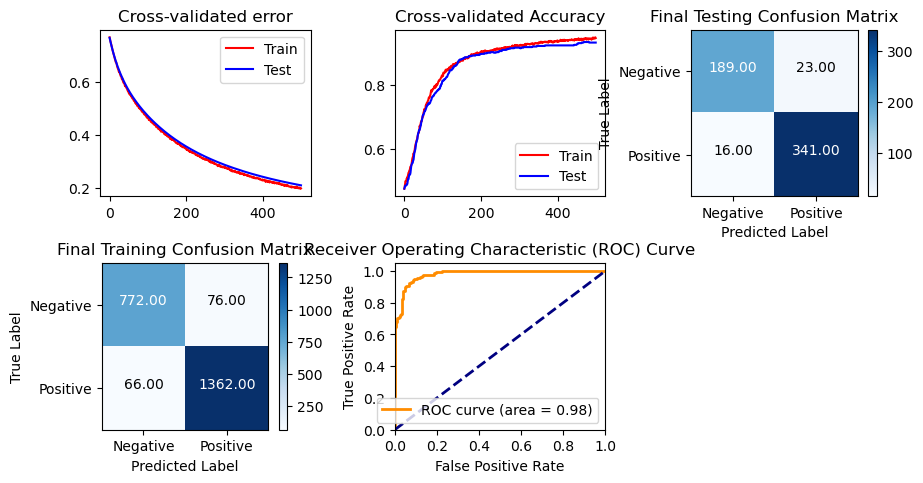

Confusion Matrix Statistics:
          Precision    Recall  F1 Score  Confusion Matrix Accuracy
Training   0.947723  0.953881  0.950533                   0.937612
Testing    0.936667  0.955691  0.945819                   0.931455


In [23]:
def test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv):
    # Load the breast cancer Wisconsin dataset
    data = load_breast_cancer()
    x = data.data
    y = data.target

    # Define the neural network architecture
    np.random.seed(0)
    input_size = x.shape[1]
    # Define the cross validation params
    kfold = KFold(n_splits=k_cv, shuffle=True, random_state=42)

    # Dictionary to store results
    scoring = {
        'accuracy': {
            'training': np.zeros((5, epochs)), 
            'testing': np.zeros((5, epochs))
        },
        'error': {
            'training': np.zeros((5, epochs)),
            'testing': np.zeros((5, epochs))
        },
        'precision': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'recall': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'f1 score': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'cm_accuracy': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'cm': {
            'training': np.zeros((2, 2)),
            'testing': np.zeros((2, 2))
        }
    }
    # Define sigmoid and its derivative
    def sigmoid(v):
        return 1 / (1 + np.exp(-np.clip(v, -500, 500)))

    def sigmoid_derivative(v):
        sig = sigmoid(v)
        sig_prime = sig * (1 - sig)
        return sig_prime
    
    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    def crossEntropy(o, y, epsilon=1e-10):

        o = np.clip(o, epsilon, 1 - epsilon)  # Clip values to avoid 0 and 1
        return (-y * np.log(o) - (1 - y) * np.log(1 - o))

    def crossEntropyDeriv(o, y, epsilon=1e-10):
        o = np.clip(o, epsilon, 1 - epsilon)  # Clip values to avoid division by zero
        return -(y / o - (1 - y) / (1 - o))

    # Mini-batch creation function
    def create_mini_batches(data, batch_size):
        num_samples = data.shape[0]
        num_batches = num_samples // batch_size

        mini_batches = [data[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

        if num_samples % batch_size != 0:
            mini_batches.append(data[num_batches * batch_size:])

        return mini_batches

    # Initialize weights and biases
    def initialize_params():
        w1 = np.random.uniform(-1, 1, (input_size, hidden_size))
        b1 = np.zeros((1, hidden_size))
        w2 = np.random.uniform(-1, 1, (hidden_size, output_size))
        b2 = np.zeros((1, output_size))
        return w1, b1, w2, b2

    # Train the model
    def train_model(X_train, y_train, X_test, y_test, epochs):
        w1, b1, w2, b2 = initialize_params()

        training_data = np.hstack((X_train, y_train.reshape(-1, 1)))

        for epoch in range(epochs):
            np.random.shuffle(training_data)

            batch_train_errors = []
            batch_train_accuracy = []

            for batch in create_mini_batches(training_data, batch_size):
                in1 = batch[:, :-1] @ w1 + b1
                o1 = sigmoid(in1)
                in2 = o1 @ w2 + b2
                o2 = sigmoid(in2)

                y_batch = batch[:, -1:]
                batch_train_errors.append(crossEntropy(o2, y_batch).mean())

                pred_train = np.where(o2 > 0.5, 1, 0)
                batch_train_accuracy.append(metrics.accuracy_score(y_batch, pred_train))

                dE_dO2 = crossEntropyDeriv(o2, y_batch)
                dO2_dIn2 = sigmoid_derivative(in2)
                dIn2_dW2 = o1
                dE_dW2 = (1 / batch.shape[0]) * dIn2_dW2.T @ (dE_dO2 * dO2_dIn2)
                dE_dB2 = (1 / batch.shape[0]) * np.ones([1, len(batch)]) @ (dE_dO2 * dO2_dIn2)

                dIn2_dO1 = w2
                dO1_dIn1 = sigmoid_derivative(in1)
                dIn1_dW1 = batch[:, :-1]
                dE_dW1 = (1 / batch.shape[0]) * dIn1_dW1.T @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)
                dE_dB1 = (1 / batch.shape[0]) * np.ones([len(batch)]) @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)

                b2 -= learning_rate * dE_dB2
                w2 -= learning_rate * dE_dW2
                b1 -= learning_rate * dE_dB1
                w1 -= learning_rate * dE_dW1

            scoring['accuracy']['training'][k, epoch] = np.array(batch_train_accuracy).mean()
            pred_test_accuracy = np.where(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
            scoring['accuracy']['testing'][k, epoch] = (metrics.accuracy_score(y_test, pred_test_accuracy))
            scoring['error']['training'][k, epoch] = (np.array(batch_train_errors).mean())
            pred_test_error = np.array(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2)).flatten()
            scoring['error']['testing'][k, epoch] = crossEntropy(pred_test_error, y_test).mean()

        return w1, b1, w2, b2

    # Update scores based on confusion matrix
    def update_scores(scoring, y_true, y_pred, dataset_type):
        conf_matrix = confusion_matrix(y_true, y_pred)
        TP, FP, FN, TN = conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[0, 0]

        scoring['cm'][dataset_type][1, 1] += TP
        scoring['cm'][dataset_type][0, 1] += FP
        scoring['cm'][dataset_type][1, 0] += FN
        scoring['cm'][dataset_type][0, 0] += TN

        precision = TP / (TP + FP)
        scoring['precision'][dataset_type][0] += precision

        recall = TP / (TP + FN)
        scoring['recall'][dataset_type][0] += recall

        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        scoring['f1 score'][dataset_type][0] += f1_score

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        scoring['cm_accuracy'][dataset_type][0] += accuracy

    k = 0

    # Cross-validated training
    for train_index, test_index in kfold.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        w1, b1, w2, b2 = train_model(X_train, y_train, X_test, y_test, epochs)
        
        final_test_predictions = np.where(sigmoid(sigmoid(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
        final_training_predictions = np.where(sigmoid(relu(X_train @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)

        update_scores(scoring, y_test, final_test_predictions, 'testing')
        update_scores(scoring, y_train, final_training_predictions, 'training')

        k += 1

    # Visualise model performance using training and testing confusion matrix's

    # get the aggregate of each column to get the mean of the cross validated accuracies for better analysis
    scoring['accuracy']['training'] = np.mean(scoring['accuracy']['training'], axis=0)
    scoring['accuracy']['testing'] = np.mean(scoring['accuracy']['testing'] , axis=0)
    scoring['error']['training'] = np.mean(scoring['error']['training'], axis=0)
    scoring['error']['testing'] = np.mean(scoring['error']['testing'], axis=0)

    # plot mean cross validated accuracy and error for more accurate evaluation

    epochs_range = np.arange(epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, scoring['error']['training'], label="Train", color='red')
    plt.plot(epochs_range, scoring['error']['testing'], label="Test", color='blue')
    plt.legend(loc='best')
    plt.title('Cross-validated error')

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, scoring['accuracy']['training'], label="Train", color='red')
    plt.plot(epochs_range, scoring['accuracy']['testing'], label="Test", color='blue')
    plt.legend(loc='best')
    plt.title('Cross-validated Accuracy')


    # plotting confusion matrice's for training and test data folds
    plt.subplot(2,3,3)
    testing_cm = scoring['cm']['testing']
    plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    plt.title('Final Testing Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add annotations
    for i in range(testing_cm.shape[0]):
        for j in range(testing_cm.shape[1]):
            plt.text(j, i, format(testing_cm[i, j], '.2f'),
                    horizontalalignment="center",
                    color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")

    # Add tick marks
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.subplot(2,3, 4)
    testing_cm = scoring['cm']['training']
    plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    plt.title('Final Training Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add annotations
    for i in range(testing_cm.shape[0]):
        for j in range(testing_cm.shape[1]):
            plt.text(j, i, format(testing_cm[i, j], '.2f'),
                    horizontalalignment="center",
                    color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")

    # Add tick marks
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Perform ROC curver graph calculations on entire dataset
    plt.subplot(2,3, 5)
    final_test_predictions = sigmoid(sigmoid(np.concatenate((X_test, X_train)) @ w1 + b1) @ w2 + b2)
    # Calculate ROC curve for the testing dataset
    fpr, tpr, thresholds = roc_curve(np.concatenate((y_test, y_train)), final_test_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Display the plot
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()


    # Print confusion matrix statistics 
    training_stats = {
        'Precision': scoring['precision']['training'][0] / 5,
        'Recall': scoring['recall']['training'][0] / 5,
        'F1 Score': scoring['f1 score']['training'][0] / 5,
        'Confusion Matrix Accuracy': scoring['cm_accuracy']['training'][0] / 5
    }

    testing_stats = {
        'Precision': scoring['precision']['testing'][0] / 5,
        'Recall': scoring['recall']['testing'][0] / 5,
        'F1 Score': scoring['f1 score']['testing'][0] / 5,
        'Confusion Matrix Accuracy': scoring['cm_accuracy']['testing'][0] / 5
    }

    df_training = pd.DataFrame(training_stats, index=['Training'])
    df_testing = pd.DataFrame(testing_stats, index=['Testing'])
    df_statistics = pd.concat([df_training, df_testing])

    print("Confusion Matrix Statistics:")
    print(df_statistics)

hidden_size = 5
output_size = 1
learning_rate = 0.01
epochs = 500
batch_size = 128
k_cv = 5
test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv)

### Network archetecture
- In this phase I experimented with the archetecture of the network by adding additional neurons and decreasing the neurons to get the best result possible

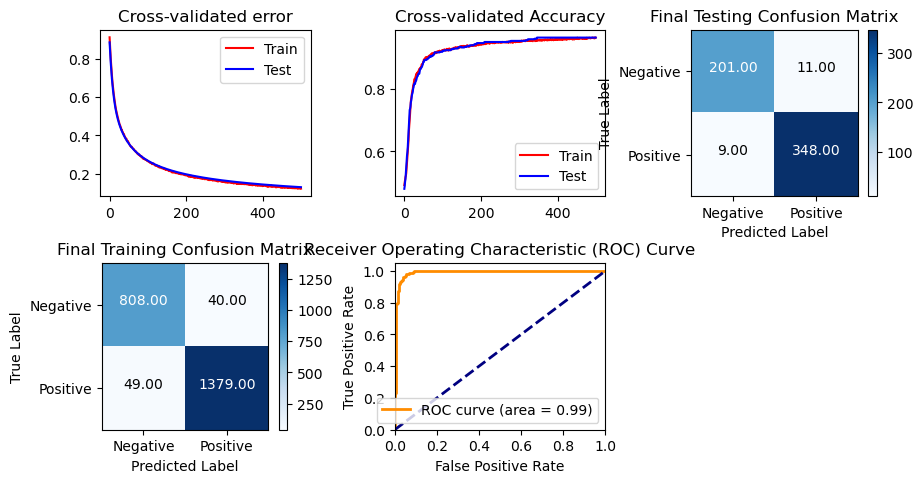

Confusion Matrix Statistics:
          Precision    Recall  F1 Score  Confusion Matrix Accuracy
Training   0.971737  0.965592  0.968637                   0.960893
Testing    0.969259  0.975409  0.971992                   0.964835


In [24]:
hidden_size = 20
test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv)

### Activation Function Experimentation
- In this example, I explored the impact of changing the activation functions for the hidden layer neurons in the model, transitioning from sigmoid to ReLU.

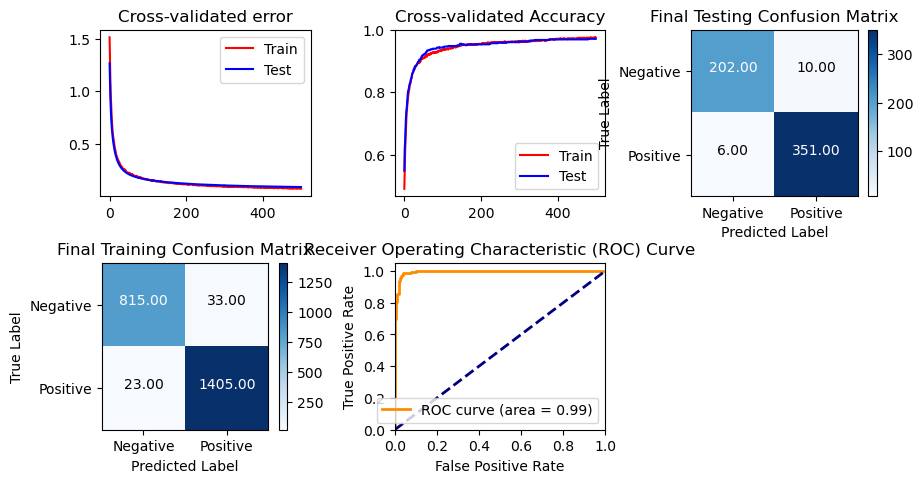

Confusion Matrix Statistics:
          Precision    Recall  F1 Score  Confusion Matrix Accuracy
Training   0.977132  0.983850  0.980445                   0.975392
Testing    0.972095  0.983808  0.977635                   0.971852


In [25]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd

def test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv):
    # Load the breast cancer Wisconsin dataset
    data = load_breast_cancer()
    x = data.data
    y = data.target

    # Define the neural network architecture
    np.random.seed(0)
    input_size = x.shape[1]
    # Define the cross validation params
    kfold = KFold(n_splits=k_cv, shuffle=True, random_state=42)

    # Dictionary to store results
    scoring = {
        'accuracy': {
            'training': np.zeros((5, epochs)), 
            'testing': np.zeros((5, epochs))
        },
        'error': {
            'training': np.zeros((5, epochs)),
            'testing': np.zeros((5, epochs))
        },
        'precision': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'recall': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'f1 score': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'cm_accuracy': {
            'training': np.zeros(1),
            'testing': np.zeros(1)
        },
        'cm': {
            'training': np.zeros((2, 2)),
            'testing': np.zeros((2, 2))
        }
    }
    # Define sigmoid and its derivative
    def sigmoid(v):
        return 1 / (1 + np.exp(-np.clip(v, -500, 500)))

    def sigmoid_derivative(v):
        sig = sigmoid(v)
        sig_prime = sig * (1 - sig)
        return sig_prime

    # Define relu and its derivative 
    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    def crossEntropy(o, y, epsilon=1e-10):

        o = np.clip(o, epsilon, 1 - epsilon)  # Clip values to avoid 0 and 1
        return (-y * np.log(o) - (1 - y) * np.log(1 - o))

    def crossEntropyDeriv(o, y, epsilon=1e-10):
        o = np.clip(o, epsilon, 1 - epsilon)  # Clip values to avoid division by zero
        return -(y / o - (1 - y) / (1 - o))

    # Mini-batch creation function
    def create_mini_batches(data, batch_size):
        num_samples = data.shape[0]
        num_batches = num_samples // batch_size

        mini_batches = [data[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

        if num_samples % batch_size != 0:
            mini_batches.append(data[num_batches * batch_size:])

        return mini_batches

    # Initialize weights and biases
    def initialize_params():
        w1 = np.random.uniform(-1, 1, (input_size, hidden_size))
        b1 = np.zeros((1, hidden_size))
        w2 = np.random.uniform(-1, 1, (hidden_size, output_size))
        b2 = np.zeros((1, output_size))
        return w1, b1, w2, b2

    # Train the model
    def train_model(X_train, y_train, X_test, y_test, epochs):
        w1, b1, w2, b2 = initialize_params()

        training_data = np.hstack((X_train, y_train.reshape(-1, 1)))

        for epoch in range(epochs):
            np.random.shuffle(training_data)

            batch_train_errors = []
            batch_train_accuracy = []

            for batch in create_mini_batches(training_data, batch_size):
                in1 = batch[:, :-1] @ w1 + b1
                o1 = relu(in1)
                in2 = o1 @ w2 + b2
                o2 = sigmoid(in2)

                y_batch = batch[:, -1:]
                batch_train_errors.append(crossEntropy(o2, y_batch).mean())

                pred_train = np.where(o2 > 0.5, 1, 0)
                batch_train_accuracy.append(metrics.accuracy_score(y_batch, pred_train))

                dE_dO2 = crossEntropyDeriv(o2, y_batch)
                dO2_dIn2 = sigmoid_derivative(in2)
                dIn2_dW2 = o1
                dE_dW2 = (1 / batch.shape[0]) * dIn2_dW2.T @ (dE_dO2 * dO2_dIn2)
                dE_dB2 = (1 / batch.shape[0]) * np.ones([1, len(batch)]) @ (dE_dO2 * dO2_dIn2)

                dIn2_dO1 = w2
                dO1_dIn1 = relu_derivative(in1)
                dIn1_dW1 = batch[:, :-1]
                dE_dW1 = (1 / batch.shape[0]) * dIn1_dW1.T @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)
                dE_dB1 = (1 / batch.shape[0]) * np.ones([len(batch)]) @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)

                b2 -= learning_rate * dE_dB2
                w2 -= learning_rate * dE_dW2
                b1 -= learning_rate * dE_dB1
                w1 -= learning_rate * dE_dW1

            scoring['accuracy']['training'][k, epoch] = np.array(batch_train_accuracy).mean()
            pred_test_accuracy = np.where(sigmoid(relu(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
            scoring['accuracy']['testing'][k, epoch] = (metrics.accuracy_score(y_test, pred_test_accuracy))
            scoring['error']['training'][k, epoch] = (np.array(batch_train_errors).mean())
            pred_test_error = np.array(sigmoid(relu(X_test @ w1 + b1) @ w2 + b2)).flatten()
            scoring['error']['testing'][k, epoch] = crossEntropy(pred_test_error, y_test).mean()

        return w1, b1, w2, b2

    # Update scores based on confusion matrix
    def update_scores(scoring, y_true, y_pred, dataset_type):
        conf_matrix = confusion_matrix(y_true, y_pred)
        TP, FP, FN, TN = conf_matrix[1, 1], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[0, 0]

        scoring['cm'][dataset_type][1, 1] += TP
        scoring['cm'][dataset_type][0, 1] += FP
        scoring['cm'][dataset_type][1, 0] += FN
        scoring['cm'][dataset_type][0, 0] += TN

        precision = TP / (TP + FP)
        scoring['precision'][dataset_type][0] += precision

        recall = TP / (TP + FN)
        scoring['recall'][dataset_type][0] += recall

        if precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0
        scoring['f1 score'][dataset_type][0] += f1_score

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        scoring['cm_accuracy'][dataset_type][0] += accuracy

    k = 0

    # Cross-validated training
    for train_index, test_index in kfold.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        w1, b1, w2, b2 = train_model(X_train, y_train, X_test, y_test, epochs)
        
        final_test_predictions = np.where(sigmoid(relu(X_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
        final_training_predictions = np.where(sigmoid(relu(X_train @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)

        update_scores(scoring, y_test, final_test_predictions, 'testing')
        update_scores(scoring, y_train, final_training_predictions, 'training')

        k += 1

    # Visualise model performance using training and testing confusion matrix's

    # get the aggregate of each column to get the mean of the cross validated accuracies for better analysis
    scoring['accuracy']['training'] = np.mean(scoring['accuracy']['training'], axis=0)
    scoring['accuracy']['testing'] = np.mean(scoring['accuracy']['testing'] , axis=0)
    scoring['error']['training'] = np.mean(scoring['error']['training'], axis=0)
    scoring['error']['testing'] = np.mean(scoring['error']['testing'], axis=0)

    # plot mean cross validated accuracy and error for more accurate evaluation

    epochs_range = np.arange(epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, scoring['error']['training'], label="Train", color='red')
    plt.plot(epochs_range, scoring['error']['testing'], label="Test", color='blue')
    plt.legend(loc='best')
    plt.title('Cross-validated error')

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, scoring['accuracy']['training'], label="Train", color='red')
    plt.plot(epochs_range, scoring['accuracy']['testing'], label="Test", color='blue')
    plt.legend(loc='best')
    plt.title('Cross-validated Accuracy')


    # plotting confusion matrice's for training and test data folds
    plt.subplot(2,3,3)
    testing_cm = scoring['cm']['testing']
    plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    plt.title('Final Testing Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add annotations
    for i in range(testing_cm.shape[0]):
        for j in range(testing_cm.shape[1]):
            plt.text(j, i, format(testing_cm[i, j], '.2f'),
                    horizontalalignment="center",
                    color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")

    # Add tick marks
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.subplot(2,3, 4)
    testing_cm = scoring['cm']['training']
    plt.imshow(testing_cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    plt.title('Final Training Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add annotations
    for i in range(testing_cm.shape[0]):
        for j in range(testing_cm.shape[1]):
            plt.text(j, i, format(testing_cm[i, j], '.2f'),
                    horizontalalignment="center",
                    color="white" if testing_cm[i, j] > testing_cm.max() / 2. else "black")

    # Add tick marks
    classes = ['Negative', 'Positive']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Perform ROC curver graph calculations on entire dataset
    plt.subplot(2,3, 5)
    final_test_predictions = sigmoid(relu(np.concatenate((X_test, X_train)) @ w1 + b1) @ w2 + b2)
    # Calculate ROC curve for the testing dataset
    fpr, tpr, thresholds = roc_curve(np.concatenate((y_test, y_train)), final_test_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Display the plot
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()


    # Print confusion matrix statistics 
    training_stats = {
        'Precision': scoring['precision']['training'][0] / 5,
        'Recall': scoring['recall']['training'][0] / 5,
        'F1 Score': scoring['f1 score']['training'][0] / 5,
        'Confusion Matrix Accuracy': scoring['cm_accuracy']['training'][0] / 5
    }

    testing_stats = {
        'Precision': scoring['precision']['testing'][0] / 5,
        'Recall': scoring['recall']['testing'][0] / 5,
        'F1 Score': scoring['f1 score']['testing'][0] / 5,
        'Confusion Matrix Accuracy': scoring['cm_accuracy']['testing'][0] / 5
    }

    df_training = pd.DataFrame(training_stats, index=['Training'])
    df_testing = pd.DataFrame(testing_stats, index=['Testing'])
    df_statistics = pd.concat([df_training, df_testing])

    print("Confusion Matrix Statistics:")
    print(df_statistics)

hidden_size = 15
output_size = 1
learning_rate = 0.01
epochs = 500
batch_size = 128
k_cv = 5
test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv)

### Hyperparameter Tuning Test
- Following preprocessing, hyperparameters were fine-tuned to optimize the model's performance. Decreasing the batch size showed slight underfitting, but marginal enhancements were achieved. Increasing the learning rate resulted in modest metric improvements. The model exhibited exponential accuracy and error trends in initial epochs, gradually improving over 450 additional epochs. While significant advancements occur within 100 epochs, the training extended to 500 epochs prioritized accuracy for thorough refinement and validation.

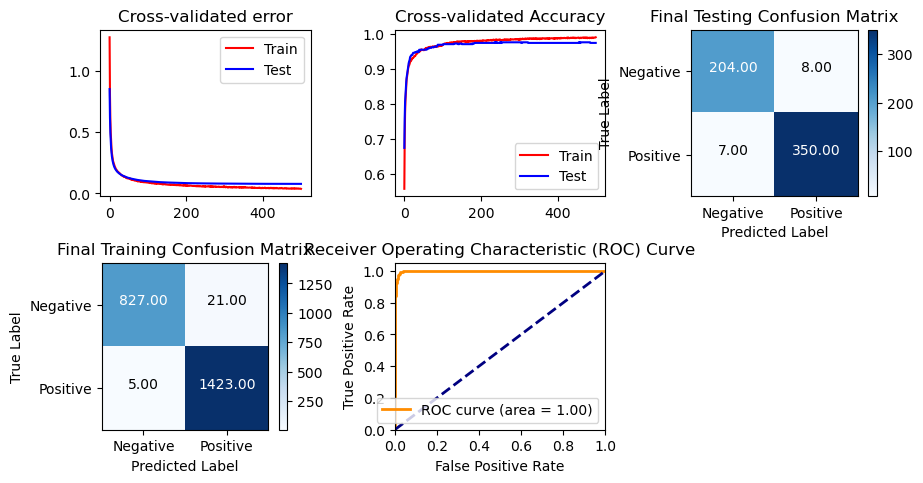

Confusion Matrix Statistics:
          Precision    Recall  F1 Score  Confusion Matrix Accuracy
Training   0.985437  0.996508  0.990939                   0.988577
Testing    0.977452  0.980992  0.978994                   0.973622


In [26]:
hidden_size = 15
output_size = 1
learning_rate = 0.03
epochs = 500
batch_size = 100 # 128
k_cv = 5
test_model(hidden_size, output_size, learning_rate, epochs, batch_size, k_cv)